### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.svm import SVC

### Get Data
<ol>
    <li> We get the, previously cleansed, <i>train</i> dataset.
    <li> We scale the numerical features <code>Age</code> and <code>Fare</code>.
</ol>

In [2]:
X = pd.read_hdf('../wip-data/X_train.h5', key = 'df')
y = pd.read_hdf('../wip-data/y_train.h5', key = 'df')

### Learning Curves
<ol>
    <li> We plot learning curves for the <i>train</i> dataset using a support vector classifier with three different kernels - <code>linear, rbf</code> and <code>polynomial</code>. This allows us to gain better insight into the bias-variance tradeoff we are likely to encounter in fitting a SVC model and better inform our choice of a appropriate model for the given dataset.
</ol>

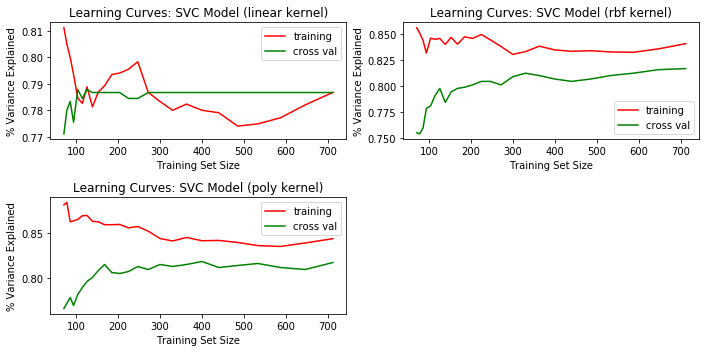

In [3]:
kernels = ['linear', 'rbf', 'poly']
plt.figure(figsize = (10,5))

for i in range(len(kernels)):
    svc = SVC(kernel = kernels[i], max_iter = -1, random_state = 1970)
    train_sizes, train_scores, val_scores = learning_curve(svc, X, y, train_sizes = np.logspace(-1, 0, 25), 
                                                           shuffle = True, random_state = 1970)
    plt.subplot(2,2,i+1)
    plt.plot(train_sizes, train_scores.mean(axis = 1), label = 'training', color = 'red')
    plt.plot(train_sizes, val_scores.mean(axis = 1), label = 'cross val', color = 'green')
    plt.xlabel('Training Set Size')
    plt.ylabel('% Variance Explained')
    plt.legend()
    plt.title('Learning Curves: SVC Model (%s kernel)' % kernels[i])

plt.tight_layout()
plt.show()

#### Observation
<ol>
    <li> The learning curves for the three kernels behave differently: For the <code>linear</code> kernel, the two curves rapidly converge indicating that a SVC Model with a <code>linear</code> kernel is likely to "suffer" from a <i>bias</i> rather than a <i>variance</i> problem. On the other hand for the other two kernels - <code>rbf</code> and <code>polynomial</code>, the two curves come closer without really converging indicating that a SVC Model with either of these kernels is likely to "suffer" from a <i>variance</i> rather than a <i>bias</i> problem.
    <li> This implies that for the <code>linear</code> kernel, the model performance can be improved by reducing the regularization in the SVC model and for the other two kernels by increasing the regularizing in the SVC model.
</ol>

### SVC Models
<ol>    
    <li> We use the <i>train-validate</i> strategy to estimate the test set accuracy.
    <li> We build models using different kernels - <code>linear, rbf</code> and <code>polynomial</code>. For each of these models we have to optimize a set of parameters to obtain the ideal results for that model. The set of paramters to optimize for each of the three models are:
        <ul>
            <li> Linear - Regularization Parameter (C)
            <li> RBF - Regularization Parameter (C), gamma
            <li> Polynomial - Retularization Paramter (C), gamma, degree (of polynomial fit), coef0 and gamma
        </ul>
    <li> We use GridSearch with 5 fold cross-validation straegy to determine the overall best model using prediction accuracy as the metric.  
    </ol>
</ol>

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1970)
svc = SVC(max_iter = -1, random_state = 1970)

In [5]:
# The range of values for gamma is centered around the value 1/(n_features) as recommended by Hastie and Tibshirani

grid = [{'kernel' : ['linear'], 'C' : [1, 10, 100]}, 
        {'kernel' : ['rbf'], 'C' : [0.01, 0.1, 1], 'gamma' : [0, 0.025, 0.05, 0.075 ,0.1]},
        {'kernel' : ['poly'], 'C' : [0.01, 0.1, 1], 'gamma' : [0, 0.025, 0.05, 0.075 ,0.1], 
         'degree' : [2, 3, 4], 'coef0' : [0, 0.25, 0.5, 0.75, 1]}]
clf = GridSearchCV(estimator = svc, param_grid = grid, scoring = 'accuracy')

clf.fit(X_train, y_train)
est_test_acc = clf.score(X_val, y_val)*100
best_params = clf.best_params_

print("The best estimated test set accuracy for the SVC model = %f" % est_test_acc,"%")
print("The parameters for the best fit SVC model are: ", best_params)



The best estimated test set accuracy for the SVC model = 82.122905 %
The parameters for the best fit SVC model are:  {'C': 1, 'coef0': 1, 'degree': 4, 'gamma': 0.05, 'kernel': 'poly'}


#### Observations
<ol>
    <li> The recommended SVC model uses a polynomial kernel of degree 4. For the other paramters of the model the optimal values are: coef0 = 1, gamma = 0.05 and regularization parameter(C) = 1.
    <li> The recommended SVC model performs (82.12%) as well as the Lasso Penalized Logistic Regression Model.
 </ol>

### Predictions
<ol>
    <li>We build a SVM classifier using the parameters identified as providing the best results in the previous step.
    <li>We fit the model to the entire <i>train</i> dataset to obtain the coeffieciets of the model.
    <li>We use the fitted model to predict for the <i>test</i> dataset.
    <li>Finally, we create the submission file in the required format.

In [92]:
svc.set_params(**best_params)

X_train, y_train = X, y
X_test = pd.read_hdf('../wip-data/X_test.h5', key = 'df')

svc.fit(X_train, y_train)
preds = svc.predict(X_test)[:, np.newaxis]
idx = np.arange(X_train.shape[0]+1, X_train.shape[0]+1+X_test.shape[0])[:, np.newaxis]

columns = ['PassengerId', 'Survived']

dat = np.hstack((idx,preds))
dat = pd.DataFrame(dat, columns = columns)
dat.to_csv('../wip-data/out_SVC.csv', index = False)